# Libaries / Modules

In [1]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import nltk
import gensim
from gensim.models import Word2Vec
from gensim.parsing.porter import PorterStemmer

stopWords = set(stopwords.words('english'))
stopWords = stopWords.union(set(['com', 'org', 'java']))

/usr/local/lib/python3.8/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
#Needed Modules
from sklearn import preprocessing
# import seaborn as sns
import re

import pandas as pd
import numpy as np

from tqdm import tqdm
 
import os
import sys
import random

import json
from pathlib import Path

import tensorflow as tf
import tensorflow_addons as tfa
import keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import CSVLogger
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sklearn.utils.class_weight
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# from plot_keras_history import plot_history
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Dense, BatchNormalization, Activation, Lambda, Flatten, Dropout, Conv1D, MaxPool1D, LSTM, GlobalMaxPooling1D, Concatenate, Bidirectional, Conv2D, Reshape, GlobalMaxPooling2D, MaxPooling2D

import matplotlib.pyplot as plt
from tensorflow.keras.backend import expand_dims, transpose

import cv2

from sklearn.preprocessing import LabelEncoder

print("Starting Notebook.")

Starting Notebook.


In [3]:
tqdm.pandas()

# Loading Data

In [4]:
SOURCE = "sakai"

# 'apache', 243k, 
# 'redhat', 106k
# 'jira', 98k

# 'mongodb', 38k
# 'qt', 36k

# 'sakai', 19k
# 'hyperledger', 16k 
# 'mariadb', 15k
# 'spring', 14k
# 'jiraecosystem', 11k

# 'sonatype', 4k, small
# 'jfrog', 3k, small
# 'inteldaos', 3k too small

# 'secondlife', 630 too small
# 'mindville', 44 too small

In [7]:
#Loading Issues & Links
filename = '../data/crawl/issues_'+SOURCE.lower()+'.csv'
issues = pd.read_csv(filename, encoding="UTF-8", low_memory=False, index_col=['issue_id'], sep=";")
print("Number of Issues: " + str(len(issues)))
print("Feature Size: " + str(len(list(issues.columns.values))))

filename = '../data/crawl/clean_links_'+SOURCE.lower()+'.csv'
links = pd.read_csv(filename, encoding="UTF-8", low_memory=False, index_col=0)
print("Number of Links: " + str(len(links)))
print("Feature Size: "+str(len(list(links.columns.values))))

Number of Issues: 49204
Feature Size: 9
Number of Links: 19057
Feature Size: 5


In [8]:
links.linktype.value_counts()

Relate             9272
Subtask            3348
Depend             2449
Duplicate          1807
Incorporate        1270
Cloners             910
Git Code Review       1
Name: linktype, dtype: int64

In [9]:
type_dict={'Backports': 'Workflow', 
           
    'Blocked': 'Temporal/Causal',
    'Blocker': 'Temporal/Causal',
    'Blocks': 'Temporal/Causal',
           
    'Bonfire Testing': 'Workflow', 
    'Bonfire testing': 'Workflow', 
    'Git Code Review': 'Workflow', 
    'Testing': 'Workflow',
           
    'Causality': 'Temporal/Causal', 
    'Cause': 'Temporal/Causal',
    'Caused': 'Temporal/Causal', 
    'Problem/Incident': 'Temporal/Causal',
           
    'Child-Issue': 'Composition', 
    'Parent Feature': 'Composition',
    'Parent/Child': 'Composition',
    'multi-level hierarchy [GANTT]': 'Composition',
    'Parent-Relation': 'Composition',
           
    'Cloners': 'Duplication', 
    'Cloners (old)': 'Duplication', 
           
    'Collection': 'Composition', 
    'Container': 'Composition', 
    'Contains(WBSGantt)': 'Composition', 
    'Incorporate': 'Composition', 
    'Incorporates': 'Composition', 
    'Part': 'Composition',
    'PartOf': 'Composition',
    'Superset': 'Composition', 
           
    'Completes': 'Workflow', 
    'Fixes': 'Workflow',
    'Resolve': 'Workflow',
           
    'Depend': 'Temporal/Causal', 
    'Dependency': 'Temporal/Causal', 
    'Dependent': 'Temporal/Causal', 
    'Depends': 'Temporal/Causal', 
    'Gantt Dependency': 'Temporal/Causal',
    'dependent': 'Temporal/Causal',
           
    'Derived': 'Workflow',
           
    'Detail': 'Workflow', 
           
    'Documentation': 'Workflow',
    'Documented': 'Workflow',
    
    'Duplicate': 'Duplication',
           
    'Epic': 'Composition', 
    'Epic-Relation': 'Composition',
    
    'Finish-to-Finish link (WBSGantt)': 'Temporal/Causal', 
    'Gantt End to End': 'Temporal/Causal', 
    'Gantt: finish-finish': 'Temporal/Causal',
    'finish-finish [GANTT]': 'Temporal/Causal', 
    
    'Gantt End to Start': 'Temporal/Causal', 
    'Gantt: finish-start': 'Temporal/Causal',
    'finish-start [GANTT]': 'Temporal/Causal',

    'Gantt Start to Start': 'Temporal/Causal', 
    
    'Gantt: start-finish': 'Temporal/Causal', 
    
    'Follows': 'Temporal/Causal', 
    'Sequence': 'Temporal/Causal', 
    
    'Implement': 'Workflow', 
    'Implements': 'Workflow', 
    
    'Issue split': 'Composition',
    'Split': 'Composition',
    'Work Breakdown': 'Composition',
    
    'Preceded By': 'Temporal/Causal', 
    
    'Reference': 'General Relation',
    'Relate': 'General Relation',
    'Related': 'General Relation', 
    'Relates': 'General Relation',
    'Relationship': 'General Relation',
    
    'Regression': 'Workflow', 
    
    'Replacement': 'Duplication',
    
    'Required': 'Temporal/Causal', 
    
    'Supercedes': 'Workflow',
    'Supersede': 'Workflow',
    'Supersession': 'Workflow', 
    
    'Test': 'Workflow', 
    'Tested': 'Workflow',
    
    'Trigger': 'Workflow',
           
    'Subtask': 'Composition',
           
    'Non-Link': 'Non-Link'}

In [10]:
links['mappedtype'] = links['linktype'].map(type_dict)
links.mappedtype.value_counts()

General Relation    9272
Composition         4618
Duplication         2717
Temporal/Causal     2449
Workflow               1
Name: mappedtype, dtype: int64

In [11]:
lt = "Duplication"

In [12]:
issues['title'].fillna(' ', inplace=True)
issues['description'].fillna(' ', inplace=True) 

## Create Embeddings

In [13]:
p = PorterStemmer()

In [15]:
textual_data = []
for issue_id in tqdm(issues.index):
    temp = []
    for word in word_tokenize(str(issues['title'].loc[issue_id])):
        word = word.lower()
        if word not in stopWords:
            word = p.stem(word)
            temp.append(word)
    textual_data.append(temp)
    temp = []
    for word in word_tokenize(str(issues['description'].loc[issue_id])):
        word = word.lower()
        if word not in stopWords:
            word = p.stem(word)
            temp.append(word)
    textual_data.append(temp)

100%|██████████| 49204/49204 [01:33<00:00, 528.05it/s] 


In [16]:
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 20
MAX_NUM_WORDS = 250000

In [17]:
model_CBOW = gensim.models.Word2Vec(textual_data, vector_size=EMBEDDING_DIM, window=5, min_count=2, workers=4, sg=0)

In [18]:
embedding_matrix = np.zeros((len(model_CBOW.wv), EMBEDDING_DIM))
for i in range(len(model_CBOW.wv)):
    embedding_vector = model_CBOW.wv[model_CBOW.wv.index_to_key[i]]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector  

In [19]:
text = []
word_count = 0

for issue_id in tqdm(issues.index):
    temp = []
    for word in word_tokenize(str(issues['title'].loc[issue_id])):
        word = word.lower()
        if word not in stopWords:
            word = p.stem(word)
            try:
                word_index = model_CBOW.wv.key_to_index[word]
                temp.append(word_index)
            except:
                word_count += 1
    for word in word_tokenize(str(issues['description'].loc[issue_id])):
        word = word.lower()
        if word not in stopWords:
            word = p.stem(word)
            try:
                word_index = model_CBOW.wv.key_to_index[word]
                temp.append(word_index)
            except:
                word_count += 1
    text.append(temp)
print(word_count)

100%|██████████| 49204/49204 [01:34<00:00, 523.19it/s] 

99591


In [20]:
text_data = pad_sequences(text, maxlen=MAX_SEQUENCE_LENGTH)

In [21]:
issues['text_word2vec']=list(text_data)

# Data Split

In [22]:
def get_linked_issues(df):
    df['issues']=''
    for i in range(len(df)):
        df["issues"].iloc[i] = str(sorted(set([df.iloc[i]['issue_id_1'], df.iloc[i]['issue_id_2']])))

## Get Link type

In [23]:
other_link_df = links[links["mappedtype"]!=lt]
print(len(other_link_df))

linktype_df = links[links["mappedtype"]==lt]
print(len(linktype_df))

16340
2717


In [24]:
random_trainval_lt, random_test_lt = train_test_split(linktype_df, test_size = 0.2, random_state = 9)

print(len(random_trainval_lt))
print(len(random_test_lt))

get_linked_issues(random_trainval_lt)
get_linked_issues(random_test_lt)

2173
544


<ipython-input-22-b21e17f7c520>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['issues']=''
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


## Get Other-Links

In [25]:
random_trainval_otherlink, random_test_otherlink = train_test_split(other_link_df, test_size = 0.2, random_state = 9)

print(len(random_trainval_otherlink))
print(len(random_test_otherlink))

get_linked_issues(random_trainval_otherlink)
get_linked_issues(random_test_otherlink)

random_trainval_ol_index = random.sample(set(random_trainval_otherlink.index), len(random_trainval_lt))
random_test_ol_index = random.sample(set(random_test_otherlink.index), len(random_test_lt))

random_trainval_ol = random_trainval_otherlink.loc[random_trainval_ol_index]
random_test_ol = random_test_otherlink.loc[random_test_ol_index]

13072
3268


<ipython-input-22-b21e17f7c520>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['issues']=''


## Create Non-Links

In [26]:
issues['resolution'].value_counts()

Fixed               30819
Open                 5622
Won't Fix            4898
Duplicate            2465
Non-Issue            2208
Incorporated         1353
Cannot Reproduce     1156
Incomplete            470
No Resources          159
Done                   38
Won't Do               16
Name: resolution, dtype: int64

In [27]:
import random
non_link_issues = set(issues[~issues['resolution'].isin(['Duplicate', 'Open'])].index)

no_issues = len(non_link_issues)

cols = ['name', 'linktype', 'mappedtype', 'issue_id_1', 'issue_id_2', 'issues']
non_links_df = pd.DataFrame(columns = cols)

for i in tqdm(range(links.mappedtype.value_counts()[lt])):
    sample = random.sample(non_link_issues, 2)
    name = str(sample[0]) + "_" + str(sample[1])
    non_links_df = non_links_df.append({
        "name": name,
        "linktype": "Non-Link",
        "mappedtype": "Non-Link",
        "issue_id_1":  sample[0],
        "issue_id_2":  sample[1],
        "issues": str(sorted(set([sample[0], sample[1]])))
    }, ignore_index=True)
    
random_trainval_nl, random_test_nl = train_test_split(non_links_df, test_size = 0.2, random_state = 9)

print(len(random_trainval_nl))
print(len(random_test_nl))

100%|██████████| 2717/2717 [00:07<00:00, 381.20it/s]

2173
544


## Merging the datasets

### Dataset 1 Link type vs Non-Links

In [28]:
random_train_1 = random_trainval_lt.append(random_trainval_nl, ignore_index=True)

print(len(random_train_1))

4346


### Dataset 2 Link type vs Other Links

In [29]:
random_train_2 = random_trainval_lt.append(random_trainval_ol, ignore_index=True)

print(len(random_train_2))

4346


### Dataset 3 Link type vs Non-Links + Other-Links

In [30]:
random_trainval_olnl_all = random_trainval_ol.append(random_trainval_nl, ignore_index=True)

random_trainval_olnl_index = random.sample(set(random_trainval_olnl_all.index), len(random_trainval_lt))

random_trainval_olnl = random_trainval_olnl_all.loc[random_trainval_olnl_index]

random_train_3 = random_trainval_lt.append(random_trainval_olnl, ignore_index=True)

print(len(random_train_3))

4346


### Dataset 4 Link type + Other-Links vs Non-Links

In [31]:
random_trainval_ollt_all = random_trainval_ol.append(random_trainval_lt, ignore_index=True)

random_trainval_ollt_index = random.sample(set(random_trainval_ollt_all.index), len(random_trainval_nl))

random_trainval_old = random_trainval_ollt_all.loc[random_trainval_ollt_index]

random_train_4 = random_trainval_nl.append(random_trainval_old, ignore_index=True)

print(len(random_train_4))

4346


### Test Set

In [32]:
random_test_temp = random_test_lt.append(random_test_nl, ignore_index=True)
random_test_lt = random_test_temp.append(random_test_ol, ignore_index=True)
random_test_linked = random_test_temp.append(random_test_ol, ignore_index=True)

print(len(random_test_lt))
print(len(random_test_linked))

1632
1632


## Clean up

In [33]:
def clean_link_set(link_df):
    # Sanity-Check for Duplicates
    print("With duplicate entries: "+str(len(link_df)))
    link_df.drop_duplicates(inplace=True)
    print("Without duplicate entries: "+str(len(link_df)))
    
    doublelinks = (link_df.issues.value_counts()>1).rename_axis('doubles').reset_index(name='valid')
    valid_doubles = set(doublelinks[doublelinks['valid']==True]['doubles'])
    
    print("With issue pairs with multiple link types: "+str(len(link_df)))
    for i in tqdm(valid_doubles):
        if len(set(link_df[link_df['issues']==i]['linktype']))>1:
            link_df=link_df[link_df.issues != i]
    print("Without issue pairs with multiple link types: "+str(len(link_df)))
    
    #Multiple links complete remove
    print("With issue pairs with multiple entries: "+str(len(link_df)))
    link_df.drop_duplicates(subset=['issues'], inplace=True)
    print("Without issue pairs with multiple entries: "+str(len(link_df)))
    
    return link_df

In [34]:
def lt_set(label):
    if label == lt:
        return 1
    elif label == 'Non-Link':
        return 0
    else:
        return 0
    
def link_set(label):
    if label == 'Non-Link':
        return 0
    else:
        return 1

In [35]:
random_sets = {'R_LTvNL_train': random_train_1, 
               'R_LTvOL_train': random_train_2, 
               'R_LTvNLOL_train': random_train_3, 
               'R_LTOLvNL_train': random_train_4,
               'R_test_lt': random_test_lt,
               'R_test_linked': random_test_linked}

In [36]:
for dataset in random_sets.keys():
    print(dataset)
    print(len(temp))
    temp = random_sets[dataset]
    temp = clean_link_set(temp)
    
    random_sets[dataset] = temp

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

R_LTvNL_train
75
With duplicate entries: 4346
Without duplicate entries: 4346
With issue pairs with multiple link types: 4346
Without issue pairs with multiple link types: 4346
With issue pairs with multiple entries: 4346
Without issue pairs with multiple entries: 4346
R_LTvOL_train
4346
With duplicate entries: 4346
Without duplicate entries: 4346
With issue pairs with multiple link types: 4346
Without issue pairs with multiple link types: 4346
With issue pairs with multiple entries: 4346
Without issue pairs with multiple entries: 4346
R_LTvNLOL_train
4346
With duplicate entries: 4346
Without duplicate entries: 4346
With issue pairs with multiple link types: 4346
Without issue pairs with multiple link types: 4346
With issue pairs with multiple entries: 4346
Without issue pairs with multiple entries: 4346
R_LTOLvNL_train
4346
With duplicate entries: 4346
Without duplicate entries: 4346
With issue pairs with multiple link types: 4346
Without issue pairs with multiple link types: 4346
Wit

In [37]:
issue_text_data = issues['text_word2vec']

In [38]:
for dataset in random_sets.keys():
    print(dataset)
    
    temp = random_sets[dataset]
    temp = temp.merge(issue_text_data, left_on='issue_id_1', right_on='issue_id')
    temp = temp.merge(issue_text_data, left_on='issue_id_2', right_on='issue_id', suffixes=('_1', '_2'))
    random_sets[dataset] = temp

R_LTvNL_train
R_LTvOL_train
R_LTvNLOL_train
R_LTOLvNL_train
R_test_lt
R_test_linked


## Linktype Mapping

In [39]:
for dataset in random_sets.keys():
    print(dataset)
    temp = random_sets[dataset]
    
    temp['mappedtype'] = temp['linktype'].map(type_dict)
    temp.mappedtype.value_counts()
    
    temp['label'] = 0
    if dataset in ['R_LTOLvNL_train', 'R_test_linked']:
        temp['label'] = temp['mappedtype'].map(link_set)
    else:
        temp['label'] = temp['mappedtype'].map(lt_set)
        
    random_sets[dataset] = temp
    
    print(temp.groupby(['mappedtype', 'label']).size())

R_LTvNL_train
mappedtype   label
Duplication  1        2173
Non-Link     0        2173
dtype: int64
R_LTvOL_train
mappedtype        label
Composition       0         589
Duplication       1        2173
General Relation  0        1253
Temporal/Causal   0         331
dtype: int64
R_LTvNLOL_train
mappedtype        label
Composition       0         294
Duplication       1        2173
General Relation  0         644
Non-Link          0        1058
Temporal/Causal   0         177
dtype: int64
R_LTOLvNL_train
mappedtype        label
Composition       1         302
Duplication       1        1044
General Relation  1         646
Non-Link          0        2173
Temporal/Causal   1         181
dtype: int64
R_test_lt
mappedtype        label
Composition       0        149
Duplication       1        544
General Relation  0        308
Non-Link          0        544
Temporal/Causal   0         87
dtype: int64
R_test_linked
mappedtype        label
Composition       1        149
Duplication       1     

# Model

In [40]:
print("Creating functions.")
def plot_history(history):
#     keys = history.history.keys()
    for i in list(history.history)[0:2]:
        print(i)
        # list all data in history
        # summarize history for accuracy
        plt.plot(history.history[i])
        plt.plot(history.history['val_'+i])
        plt.title('model '+ i)
        plt.ylabel(i)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

Creating functions.


## SC-CNN Model

In [41]:
print("Disabling eager execution.")
tf.compat.v1.disable_eager_execution()

print("Models incoming.")
embedding_layer = Embedding(len(model_CBOW.wv),
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
# from keras.layers import concatenate
text_in = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'Text_Input')
text_out = embedding_layer(text_in)

text_embedding = Model(inputs = [text_in], outputs = [text_out], name = 'Text_Output')
text_embedding.summary()

Disabling eager execution.
Models incoming.
Model: "Text_Output"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Text_Input (InputLayer)      [(None, 300)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 20)           1225480   
Total params: 1,225,480
Trainable params: 0
Non-trainable params: 1,225,480
_________________________________________________________________


In [42]:
def SCCNN_Model():
    text_in = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='Text_Input')

    text_out = text_embedding([text_in])
    
    text_out = expand_dims(text_out, axis=-1)

     # A branch
    conv_a = Conv2D(filters=100,
                    kernel_size=(1,20),
                    strides=(1,1),
                    activation='relu',
                    name="BranchA"
                    )(text_out)
    
    conv_a = BatchNormalization(axis=-1)(conv_a)

    conv_a_rs = Reshape((300,100,1))(conv_a)

    conv_a_1 = Conv2D(filters = 200,
                    kernel_size = (1,100),
                    strides=(1,1),
                    activation = 'relu',
                    name="BranchA1"
                    )(conv_a_rs)

    pooled_conv_a_1 = MaxPooling2D(pool_size=(conv_a_1.shape[1], 1), padding='valid')(conv_a_1)
#     pooled_conv_a_1 = GlobalMaxPooling2D()(conv_a_1)
    pooled_conv_a_1 = Flatten()(pooled_conv_a_1)

    conv_a_2 = Conv2D(filters = 200,
                    kernel_size = (2,100),
                    activation = 'relu',
                    strides=(1,1),
                    name="BranchA2"
                    )(conv_a_rs)

    pooled_conv_a_2 = MaxPooling2D(pool_size=(conv_a_2.shape[1], 1), padding='valid')(conv_a_2)
#     pooled_conv_a_2 = GlobalMaxPooling2D()(conv_a_2)
    pooled_conv_a_2 = Flatten()(pooled_conv_a_2)

    conv_a_3 = Conv2D(filters = 200,
                    kernel_size = (3,100),
                    activation = 'relu',
                    strides=(1,1),
                    name="BranchA3"
                    )(conv_a_rs)

    pooled_conv_a_3 = MaxPooling2D(pool_size=(conv_a_3.shape[1], 1), padding='valid')(conv_a_3)
#     pooled_conv_a_3 = GlobalMaxPooling2D()(conv_a_3)
    pooled_conv_a_3 = Flatten()(pooled_conv_a_3)
    
    A = Concatenate(axis=-1)([pooled_conv_a_1,pooled_conv_a_2])
    A = Concatenate(axis=-1)([A,pooled_conv_a_3])
    
    # B branch
    conv_b = Conv2D(filters=100,
                    kernel_size=(2,20),
                    activation='relu',
                    strides=(1,1),
                    name="BranchB"
                    )(text_out)

    conv_b = BatchNormalization(axis=-1)(conv_b)

    conv_b_rs = Reshape((299,100,1))(conv_b)

    conv_b_1 = Conv2D(filters = 200,
                    kernel_size = (1,100),
                    activation = 'relu',
                    strides=(1,1),
                    name="BranchB1"
                    )(conv_b_rs)

    pooled_conv_b_1 = MaxPooling2D(pool_size=(conv_b_1.shape[1], 1), padding='valid')(conv_b_1)
#     pooled_conv_b_1 = GlobalMaxPooling2D()(conv_b_1)
    pooled_conv_b_1 = Flatten()(pooled_conv_b_1)

    conv_b_2 = Conv2D(filters = 200,
                    kernel_size = (2,100),
                    activation = 'relu',
                    strides=(1,1),
                    name="BranchB2"
                    )(conv_b_rs)

    pooled_conv_b_2 = MaxPooling2D(pool_size=(conv_b_2.shape[1], 1), padding='valid')(conv_b_2)
#     pooled_conv_b_2 = GlobalMaxPooling2D()(conv_b_2)
    pooled_conv_b_2 = Flatten()(pooled_conv_b_2)

    conv_b_3 = Conv2D(filters = 200,
                    kernel_size = (3,100),
                    activation = 'relu',
                    strides=(1,1),
                    name="BranchB3"
                    )(conv_b_rs)

    pooled_conv_b_3 = MaxPooling2D(pool_size=(conv_b_3.shape[1], 1), padding='valid')(conv_b_3)
#     pooled_conv_b_3 = GlobalMaxPooling2D()(conv_b_3)
    pooled_conv_b_3 = Flatten()(pooled_conv_b_3)
    
    B = Concatenate(axis=-1)([pooled_conv_b_1,pooled_conv_b_2])
    B = Concatenate(axis=-1)([B,pooled_conv_b_3])

    # C branch
    conv_c = Conv2D(filters=100,
                    kernel_size=(3,20),
                    activation='relu',
                    strides=(1,1),
                    name="BranchC"
                    )(text_out)
    conv_c = BatchNormalization(axis=-1)(conv_c)

    conv_c_rs = Reshape((298,100,1))(conv_c)

    conv_c_1 = Conv2D(filters = 200,
                    kernel_size = (1,100),
                    activation = 'relu',
                    strides=(1,1),
                    name="BranchC1"
                    )(conv_c_rs)


    pooled_conv_c_1 = MaxPooling2D(pool_size=(conv_c_1.shape[1], 1), padding='valid')(conv_c_1)
#     pooled_conv_c_1 = GlobalMaxPooling2D()(conv_c_1)
    pooled_conv_c_1 = Flatten()(pooled_conv_c_1)

    conv_c_2 = Conv2D(filters = 200,
                    kernel_size = (2,100),
                    activation = 'relu',
                    strides=(1,1),
                    name="BranchC2"
                    )(conv_c_rs)

    pooled_conv_c_2 = MaxPooling2D(pool_size=(conv_c_2.shape[1], 1), padding='valid')(conv_c_2)
#     pooled_conv_c_2 = GlobalMaxPooling2D()(conv_c_2)
    pooled_conv_c_2 = Flatten()(pooled_conv_c_2)

    conv_c_3 = Conv2D(filters = 200,
                    kernel_size = (3,100),
                    activation = 'relu',
                    strides=(1,1),
                    name="BranchC3"
                    )(conv_c_rs)

    pooled_conv_c_3 = MaxPooling2D(pool_size=(conv_c_3.shape[1], 1), padding='valid')(conv_c_3)
#     pooled_conv_c_3 = GlobalMaxPooling2D()(conv_c_3)
    pooled_conv_c_3 = Flatten()(pooled_conv_c_3)
    
    C = Concatenate(axis=-1)([pooled_conv_c_1,pooled_conv_c_2])
    C = Concatenate(axis=-1)([C,pooled_conv_c_3])

    conv_concat = Concatenate(axis=-1)([A,B])
    conv_concat = Concatenate(axis=-1)([conv_concat,C])

    issue_model = Model(inputs = [text_in], outputs = [conv_concat], name = 'DC-CNN_Model')

#     issue_model.summary()
    return issue_model

In [43]:
def get_sim_model():
    text_in_a = Input(shape = (MAX_SEQUENCE_LENGTH,), dtype='int32', name="Text_issue_a")
    text_in_b = Input(shape = (MAX_SEQUENCE_LENGTH,), dtype='int32', name="Text_issue_b")

    issue_model = SCCNN_Model()

    encoded_issue_a = issue_model([text_in_a])
    encoded_issue_b = issue_model([text_in_b])

    merged_vector = Concatenate()([encoded_issue_a, encoded_issue_b])

    conv_concat = Dropout(0.6)(merged_vector)
    concat = Dense(units = 300, 
                activation = 'relu',
                )(conv_concat)
    concat = BatchNormalization(axis=-1)(merged_vector)

    concat = Dropout(0.4)(concat)
    concat = Dense(units = 100, 
                activation = 'relu',
                )(concat)
    concat = BatchNormalization(axis=-1)(concat)

    concat = Dropout(0.4)(concat)
    concat = Dense(units = 1, # dimensionality of the output space
                activation = 'sigmoid',
                )(concat)

    sim_model = Model(inputs=[text_in_a, text_in_b], outputs=concat)
#     sim_model.summary()
    
    return sim_model

In [44]:
def train_model(train):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, verbose=2)

    sim_model = get_sim_model()

    sim_model.compile(optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), loss='binary_crossentropy', metrics=['accuracy'])
    
    train_issue_1 = train['text_word2vec_1']
    train_issue_1 = np.array(train_issue_1.values.tolist())

    train_issue_2 = train['text_word2vec_2']
    train_issue_2 = np.array(train_issue_2.values.tolist())
    
    history = sim_model.fit([train_issue_1, train_issue_2], 
                        y=train['label'], callbacks=[callback], validation_split=0.1, 
#                         class_weight = dict(enumerate(class_weight)), 
                        batch_size=64, epochs=100, verbose=0)
    plot_history(history)
    
    return sim_model

In [45]:
def eval_model(model, test, link):    
    test_issue_1 = test['text_word2vec_1']
    test_issue_1 = np.array(test_issue_1.values.tolist())

    test_issue_2 = test['text_word2vec_2']
    test_issue_2 = np.array(test_issue_2.values.tolist())
    
    probs = model.predict([test_issue_1, test_issue_2])

    probs = probs.flatten()
    
    rounded_preds = np.round(probs).astype(int)
    
    class_rep = classification_report(test['label'], rounded_preds, output_dict=True)
    class_rep_df = pd.DataFrame(class_rep).transpose()
    
    auc = metrics.roc_auc_score(test['label'], probs)
    acc = class_rep_df['precision'].loc['accuracy']
    
    print(class_rep_df)

    conf_mat = confusion_matrix(test['label'], rounded_preds)

    print(pd.DataFrame(conf_mat, index=[0, 1], columns=[0, 1]))

    print("AUC: "+str(auc))
       
    df_test_preds = test
    df_test_preds['pred'] = rounded_preds
    
    conf_mat_comp = df_test_preds.groupby(['mappedtype', 'pred']).size()
    
    lt_preds = df_test_preds[(df_test_preds['mappedtype']==lt)][['mappedtype', 'pred']]
    ol_preds = df_test_preds[(df_test_preds['mappedtype']!='Non-Link')&(df_test_preds['mappedtype']!=lt)][['mappedtype', 'pred']]    
    nl_preds = df_test_preds[(df_test_preds['mappedtype']=='Non-Link')][['mappedtype', 'pred']]
    
    lt_cf = lt_preds['pred'].value_counts()
    ol_cf = ol_preds['pred'].value_counts()
    nl_cf = nl_preds['pred'].value_counts()
    
    try:
        LT0 = lt_cf[0]
    except:
        LT0 = 0
        
    try:    
        LT1 = lt_cf[1]
    except:
        LT1 = 0
        
    try:
        OL0 = ol_cf[0]
    except:
        OL0 = 0
        
    try:
        OL1 = ol_cf[1]
    except:
        OL1 = 0
        
    try:
        NL0 = nl_cf[0]
    except:
        NL0 = 0
        
    try:
        NL1 = nl_cf[1]
    except:
        NL1 = 0
    
    conf_mat_df = pd.DataFrame(columns = ['Class', '0', '1'])
    
    conf_mat_df.loc[len(conf_mat_df)] = [lt.upper(), LT0, LT1]
    conf_mat_df.loc[len(conf_mat_df)] = ["OTHER-LINKS", OL0, OL1]
    conf_mat_df.loc[len(conf_mat_df)] = ["NON-LINKS", NL0, NL1]
    
    print(conf_mat_df)
    
    if link:
        try:
            lt_pre = LT1 / (LT1+NL1)
        except:
            lt_pre = 0
        lt_rec = LT1 / (LT1+LT0)
    
        try:
            ol_pre = OL1 / (OL1+NL1)
        except:
            ol_pre = 0
        ol_rec = OL1 / (OL1+OL0)
        
        try:
            nl_pre = NL0 / (NL0+LT0+OL0)
        except:
            nl_pre = 0
        nl_rec = NL0 / (NL0+NL1)
        
        both_metrics = class_rep_df.loc['1'].to_list()
        
    else:
        try:
            lt_pre = LT1 / (LT1+OL1+NL1)
        except:
            lt_pre = 0
        lt_rec = LT1 / (LT1+LT0)
        
        try:
            ol_pre = OL0 / (LT0+OL0)
        except:
            ol_pre = 0
        ol_rec = OL0 / (OL0+OL1)
        
        try:
            nl_pre = NL0 / (LT0+NL0)
        except:
            nl_pre = 0
        nl_rec = NL0 / (NL0+NL1)
        
        both_metrics = class_rep_df.loc['0'].to_list()

    lt_f1 = 2*(lt_pre*lt_rec)/(lt_pre+lt_rec)
    
    ol_f1 = 2*(ol_pre*ol_rec)/(ol_pre+ol_rec)
        
    nl_f1 = 2*(nl_pre*nl_rec)/(nl_pre+nl_rec)
    
    lt_metrics = [lt, lt_pre, lt_rec, lt_f1]
    ol_metrics = ['Other-Links', ol_pre, ol_rec, ol_f1]
    nl_metrics = ['Non-Links', nl_pre, nl_rec, nl_f1]
    
    both_metrics.insert(0, 'Both')
    both_metrics = both_metrics[:-1]

    print(conf_mat_comp)
    
    return acc, auc, lt_metrics, ol_metrics, nl_metrics, both_metrics, conf_mat_df, df_test_preds

In [46]:
def do_model(dataset):
    sccnn_model = train_model(random_sets[dataset+'_train'])
    if dataset == 'R_LTOLvNL':
        metrics_df, accauc_df, conf_mat_df, df_test_preds = do_test(sccnn_model, 'R_test_linked', True)
        
    else: 
        metrics_df, accauc_df, conf_mat_df, df_test_preds = do_test(sccnn_model, 'R_test_lt', False)
    
    metrics_df.to_csv('results/sccnn_'+SOURCE+'_'+lt+'_'+dataset+'_metrics.csv', encoding='utf-8', index=False)
    accauc_df.to_csv('results/sccnn_'+SOURCE+'_'+lt+'_'+dataset+'_accauc.csv', encoding='utf-8', index=False)
    conf_mat_df.to_csv('results/sccnn_'+SOURCE+'_'+lt+'_'+dataset+'_confmat.csv', encoding='utf-8', index=False)
   
    print(conf_mat_df)
    print(accauc_df)
    print(metrics_df)
    
    return df_test_preds

def do_test(model, dataset, link):
    acc, auc, lt_metrics, ol_metrics, nl_metrics, both_metrics, conf_mat_df, df_test_preds = eval_model(model, random_sets[dataset], link)

    accauc_df = pd.DataFrame(columns = ['Dataset', 'ACC', 'AUC'])
    accauc_df = accauc_df.append({
        "Dataset": dataset,
        "ACC": acc,
        "AUC": auc
    }, ignore_index=True)

    metrics_df = pd.DataFrame(columns = ['Class', 'Precision', 'Recall', 'F1'])
    metrics_df.loc[len(metrics_df)] = lt_metrics
    metrics_df.loc[len(metrics_df)] = nl_metrics
    metrics_df.loc[len(metrics_df)] = ol_metrics
    metrics_df.loc[len(metrics_df)] = both_metrics
    
    return metrics_df, accauc_df, conf_mat_df, df_test_preds

## Random

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 00035: early stopping
loss


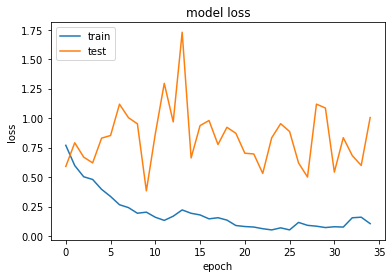

accuracy


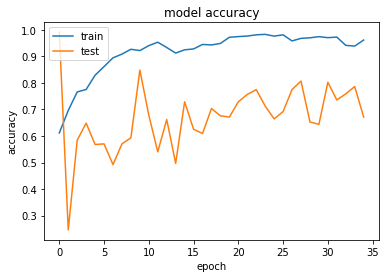

              precision    recall  f1-score      support
0              0.920065  0.518382  0.663139  1088.000000
1              0.485770  0.909926  0.633397   544.000000
accuracy       0.648897  0.648897  0.648897     0.648897
macro avg      0.702918  0.714154  0.648268  1632.000000
weighted avg   0.775300  0.648897  0.653225  1632.000000
     0    1
0  564  524
1   49  495
AUC: 0.8006815662846021
         Class    0    1
0  DUPLICATION   49  495
1  OTHER-LINKS  197  347
2    NON-LINKS  367  177
mappedtype        pred
Composition       0        73
                  1        76
Duplication       0        49
                  1       495
General Relation  0        85
                  1       223
Non-Link          0       367
                  1       177
Temporal/Causal   0        39
                  1        48
dtype: int64
         Class    0    1
0  DUPLICATION   49  495
1  OTHER-LINKS  197  347
2    NON-LINKS  367  177
     Dataset       ACC       AUC
0  R_test_lt  0.648897  0.800

In [47]:
LTvNL_preds = do_model('R_LTvNL')

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 00031: early stopping
loss


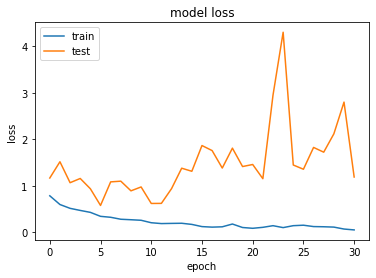

accuracy


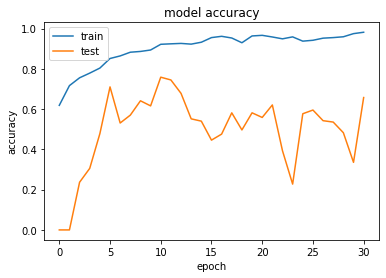

              precision    recall  f1-score      support
0              0.818841  0.623162  0.707724  1088.000000
1              0.490050  0.724265  0.584570   544.000000
accuracy       0.656863  0.656863  0.656863     0.656863
macro avg      0.654445  0.673713  0.646147  1632.000000
weighted avg   0.709244  0.656863  0.666673  1632.000000
     0    1
0  678  410
1  150  394
AUC: 0.7292767693014706
         Class    0    1
0  DUPLICATION  150  394
1  OTHER-LINKS  385  159
2    NON-LINKS  293  251
mappedtype        pred
Composition       0       131
                  1        18
Duplication       0       150
                  1       394
General Relation  0       187
                  1       121
Non-Link          0       293
                  1       251
Temporal/Causal   0        67
                  1        20
dtype: int64
         Class    0    1
0  DUPLICATION  150  394
1  OTHER-LINKS  385  159
2    NON-LINKS  293  251
     Dataset       ACC       AUC
0  R_test_lt  0.656863  0.729

In [48]:
LTvOL_preds = do_model('R_LTvOL')

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 00045: early stopping
loss


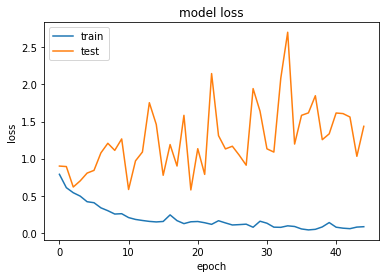

accuracy


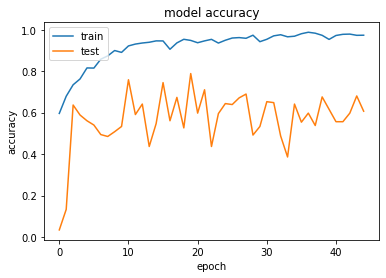

              precision    recall  f1-score      support
0              0.846433  0.643382  0.731070  1088.000000
1              0.518012  0.766544  0.618236   544.000000
accuracy       0.684436  0.684436  0.684436     0.684436
macro avg      0.682223  0.704963  0.674653  1632.000000
weighted avg   0.736959  0.684436  0.693459  1632.000000
     0    1
0  700  388
1  127  417
AUC: 0.780392551092128
         Class    0    1
0  DUPLICATION  127  417
1  OTHER-LINKS  340  204
2    NON-LINKS  360  184
mappedtype        pred
Composition       0       116
                  1        33
Duplication       0       127
                  1       417
General Relation  0       161
                  1       147
Non-Link          0       360
                  1       184
Temporal/Causal   0        63
                  1        24
dtype: int64
         Class    0    1
0  DUPLICATION  127  417
1  OTHER-LINKS  340  204
2    NON-LINKS  360  184
     Dataset       ACC       AUC
0  R_test_lt  0.684436  0.7803

In [49]:
LTvNLOL_preds = do_model('R_LTvNLOL')

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 00060: early stopping
loss


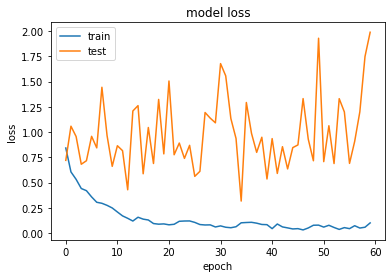

accuracy


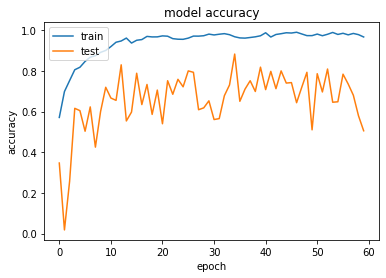

              precision    recall  f1-score      support
0              0.487660  0.908088  0.634554   544.000000
1              0.919225  0.522978  0.666667  1088.000000
accuracy       0.651348  0.651348  0.651348     0.651348
macro avg      0.703442  0.715533  0.650610  1632.000000
weighted avg   0.775370  0.651348  0.655962  1632.000000
     0    1
0  494   50
1  519  569
AUC: 0.8363598886245676
         Class    0    1
0  DUPLICATION  245  299
1  OTHER-LINKS  274  270
2    NON-LINKS  494   50
mappedtype        pred
Composition       0        57
                  1        92
Duplication       0       245
                  1       299
General Relation  0       165
                  1       143
Non-Link          0       494
                  1        50
Temporal/Causal   0        52
                  1        35
dtype: int64
         Class    0    1
0  DUPLICATION  245  299
1  OTHER-LINKS  274  270
2    NON-LINKS  494   50
         Dataset       ACC      AUC
0  R_test_linked  0.651348

In [50]:
LTOLvNL_preds = do_model('R_LTOLvNL')